In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as tm

import torch 
from models import RateModel
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA

# Save figures?
SaveFigs=True

device='cpu'
print('Device =',device)

# seed rng
torch.manual_seed(0)



####### Set parameter values

# Number of neurons in recurrent net
N = 200

# Parameters for connectivity matrix
c=-10
rho=0.5


# Time step size, timescale of dynamics
dt = 0.01
tau = 1



###### Generate variables 

# Direction, u, of low rank part
u = torch.randn(N).to(device)
u *= 1/u.norm()
v = u

# Connectivity
W0 = c*torch.outer(u,v)
W1 = rho*torch.randn(N,N).to(device)/np.sqrt(N)
W = W0 + W1

# Low rank feedforward matrix.
# We will multiply Wx by x to reduce its dimension
ux = torch.randn(N).to(device)
ux = ux/ux.norm()
vx=ux
Wx0 = c*torch.outer(ux,vx)
Wx1 = rho*torch.randn(N,N).to(device)/np.sqrt(N)
Wx = Wx0 + Wx1


# Random direction
urand = torch.randn(N).to(device)
urand *= 1/urand.norm()

# Coefficient for RNN Euler integrator
eta = dt/tau

# Model and random model
model = RateModel(W, f='id', eta = eta, bias_recurrent=False, Network_Type='Z').to(device)

# singular values and eigenvalues of connectivity
with torch.no_grad():
    sigmaW = torch.linalg.svdvals(W.cpu())
    lamW = torch.linalg.eigvals(W.cpu())
    #print('max real e-val of W:',torch.real(lamW).max().item())



####### Second simulations (panels e-h and Supp Fig?)

# Duration of sim
T2=5000

# Timescale and strength of Guassian random stimulus
taux=10
sigmax=1

# Discretized time for second sim
time2=np.arange(0,T2,dt)
Nt2=len(time2)


# Generate input and run sim
with torch.no_grad():
    t0=tm()
    x2 = sigmax*MakeSmoothGaussianProcess(taux,Nt2,dt,N,device=device).T
    x2 = x2[None,:,:].float().to(device)
    x2 = x2@Wx
    tx = tm()-t0
    print('Time to generate x(t):',tx,'s')
    t0=tm()
    r2 = model(x2, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    z2 = model.hidden_state_history

    # r3 = rand_model(x2, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    # z3 = rand_model.hidden_state_history
    
    tsim2 = tm()-t0
    print('Time for second sim:',tsim2,'s')

# Perform PCA on x and z
t0=tm()
Ux,Sx=TorchPCA(x2[0,:,:], scaled=False)
Uz,Sz=TorchPCA(z2[0,:,:], scaled=False)
print('Time for PCA calc:',tm()-t0)


# Get input variable
y2=model.recurrent_layer(r2)


# Define projected variables
xu = x2[0,:,:]@u
xurand = x2[0,:,:]@urand
zu = z2[0,:,:]@u
zurand = z2[0,:,:]@urand
yu = y2[0,:,:]@u
ru = r2[0,:,:]@u

xycorr = torch.corrcoef(torch.stack((xu,yu)))[0,1].item()
print('corr coef between xu and yu=Wru:',xycorr)


uuangle=(180/np.pi)*torch.arccos(torch.nn.functional.cosine_similarity(Uz[:,-1],u.cpu(),dim=0)).item()
print('Angle btwn smallest sing vec and u:',uuangle,'degrees')

ratio2=(zurand.var()/zu.var()).item()
print('Ratio between var in direction u vs urand:',ratio2)


Device = cpu
Time to generate x(t): 1.4940121173858643 s
Time for second sim: 11.639908075332642 s
Time for PCA calc: 3.03617787361145
corr coef between xu and yu=Wru: -0.9990507364273071
Angle btwn smallest sing vec and u: 162.06473421082492 degrees
Ratio between var in direction u vs urand: 174.9575958251953


done


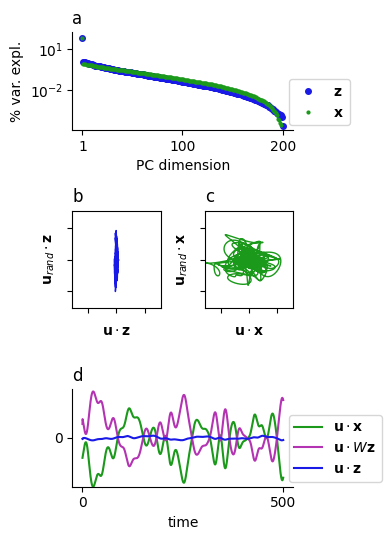

In [2]:

### Make Figure
xclr = [.1,.6,.1]
yclr = [.7,.2,.7]
zclr = [.1,.1,.9]
Wclr = [.8,.1,.1]

numplot = N

fig, axes = plt.subplot_mosaic("aa;bc;dd",figsize=(4,5.5))




c0='a'
ax0 = axes[c0]
ax0.plot(np.arange(N)+1,100*Sz/Sz.sum(),'o',label=r'$\mathbf{z}$',markersize=4,color=zclr)
ax0.plot(np.arange(N)+1,100*Sx/Sx.sum(),'.',label=r'$\mathbf{x}$',markersize=4,color=xclr)
#ax0.plot(np.arange(N)+1,100*SCzlin/SCzlin.sum(),'.',label=r'$\mathbf{z}\;(W=W_1)$',markersize=2,color='r')
ax0.set_xscale('linear')
ax0.set_yscale('log')
ax0.set_xlabel('PC dimension')
ax0.set_xticks([1,int(N/2),N])
ax0.set_ylim(bottom=(100*Sz/Sz.sum()).min()*.5)
ax0.set_ylabel('% var. expl.')
ax0.legend(loc=(.98,.05))
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)


c0='b'
ax0 = axes[c0]
xumax=torch.max(torch.cat((torch.abs(xu),torch.abs(xurand)))).item()
zumax=torch.max(torch.cat((torch.abs(zu),torch.abs(zurand)))).item()
xzumax=max(xumax,zumax)

I2plot=int(2000/dt)
numplot=N
ax0.plot(ToNP(zu[:I2plot]),ToNP(zurand[:I2plot]),color=zclr,lw=1)
ax0.axis([-xzumax,xzumax,-xzumax,xzumax])
ax0.set_xticks([-2,0,2])
ax0.set_yticks([-2,0,2])
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_xlabel(r'$\mathbf{u}\cdot\mathbf{z}$')
ax0.set_ylabel(r'$\mathbf{u}_{rand}\cdot\mathbf{z}$')
ax0.set_title(c0,loc='left')

c0='c'
ax0 = axes[c0]
ax0.plot(ToNP(xu[:I2plot]),ToNP(xurand[:I2plot]),color=xclr,lw=1)
ax0.axis([-xzumax,xzumax,-xzumax,xzumax])
ax0.set_xticks([-2,0,2])
ax0.set_yticks([-2,0,2])
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_xlabel(r'$\mathbf{u}\cdot\mathbf{x}$')
ax0.set_ylabel(r'$\mathbf{u}_{rand}\cdot\mathbf{x}$')
ax0.set_title(c0,loc='left')

c0='d'
ax0 = axes[c0]
I1plot=int(.2/dt)
I2plot=int(500/dt)
xumax=torch.max(torch.abs(xu[:I2plot])).item() 
zumax=torch.max(torch.abs(zu[:I2plot])).item()
xzumax=max(xumax,zumax)
ax0.plot(time2[I1plot:I2plot],ToNP(xu[I1plot:I2plot]),label=r'$\mathbf{u}\cdot\mathbf{x}$', color=xclr)
ax0.plot(time2[I1plot:I2plot],ToNP(yu[I1plot:I2plot]),label=r'$\mathbf{u}\cdot W\mathbf{z}$', color=yclr)
ax0.plot(time2[I1plot:I2plot],ToNP(zu[I1plot:I2plot]),label=r'$\mathbf{u}\cdot\mathbf{z}$', color=zclr)
ax0.set_xticks([0,int(I2plot*dt)])
ax0.set_yticks([-2,0,2])
ax0.set_ylim([-xzumax,xzumax])
ax0.set_xlabel('time')
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)
ax0.legend(loc=(.98,.05))

fig.tight_layout()


if SaveFigs:
    fig.savefig('./Figures/SuppFigLowDimInput.pdf')
    fig.savefig('./Figures/SuppFigLowDimInputunpolished.svg')


print('done')

